In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_predict
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense, LSTM

In [2]:
start_date = '2020-01-01'
end_date = '2023-12-1'



# Split the data into training and test sets
df_tsla = yf.download("TSLA", start_date , end_date)['Close']

# Calculate the split point
split_index = int(len(df_tsla) * 0.8)
train_df_tsla = df_tsla[:split_index]
test_df_tsla = df_tsla[split_index:]

# Print the number of data points in each set
print("Training set size:", len(train_df_tsla))
print("Test set size:", len(test_df_tsla))

[*********************100%%**********************]  1 of 1 completed
Training set size: 788
Test set size: 198


In [3]:
# Calculate the difference and remove NaN values
log_train_df_tsla = np.log(np.log(train_df_tsla))
diff_train_df_tsla = train_df_tsla.diff().dropna()

diff_test_df_tsla = test_df_tsla.diff().dropna()

### Visualize Tesla Share Price

In [4]:
def plot_share_price(series):
    plt.figure(figsize=(12,4))
    series.plot()
    plt.grid()
    plt.ylabel("Price")
    plt.title("Tesla Share Price", fontsize = 14)
    plt.show()

In [5]:
def plot_returns_distributions(series):

    # Calculate daily, weekly, and monthly returns
    daily_returns = series.pct_change().dropna()
    weekly_returns = series.resample('W').ffill().pct_change().dropna()
    monthly_returns = series.resample('M').ffill().pct_change().dropna()

    # Create a 1x3 subplot
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Plot the distribution of daily returns
    sns.histplot(daily_returns, bins=30, kde=True, color='skyblue', ax=axes[0])
    axes[0].set_title('Daily Returns')
    axes[0].set_xlabel('Daily Returns')
    axes[0].set_ylabel('Frequency')
    axes[0].grid(True)

    # Plot the distribution of weekly returns
    sns.histplot(weekly_returns, bins=30, kde=True, color='green', ax=axes[1])
    axes[1].set_title('Weekly Returns')
    axes[1].set_xlabel('Weekly Returns')
    axes[1].set_ylabel('Frequency')
    axes[1].grid(True)

    # Plot the distribution of monthly returns
    sns.histplot(monthly_returns, bins=30, kde=True, color='orange', ax=axes[2])
    axes[2].set_title('Monthly Returns')
    axes[2].set_xlabel('Monthly Returns')
    axes[2].set_ylabel('Frequency')
    axes[2].grid(True)

    # Adjust layout
    plt.tight_layout()
    plt.show()

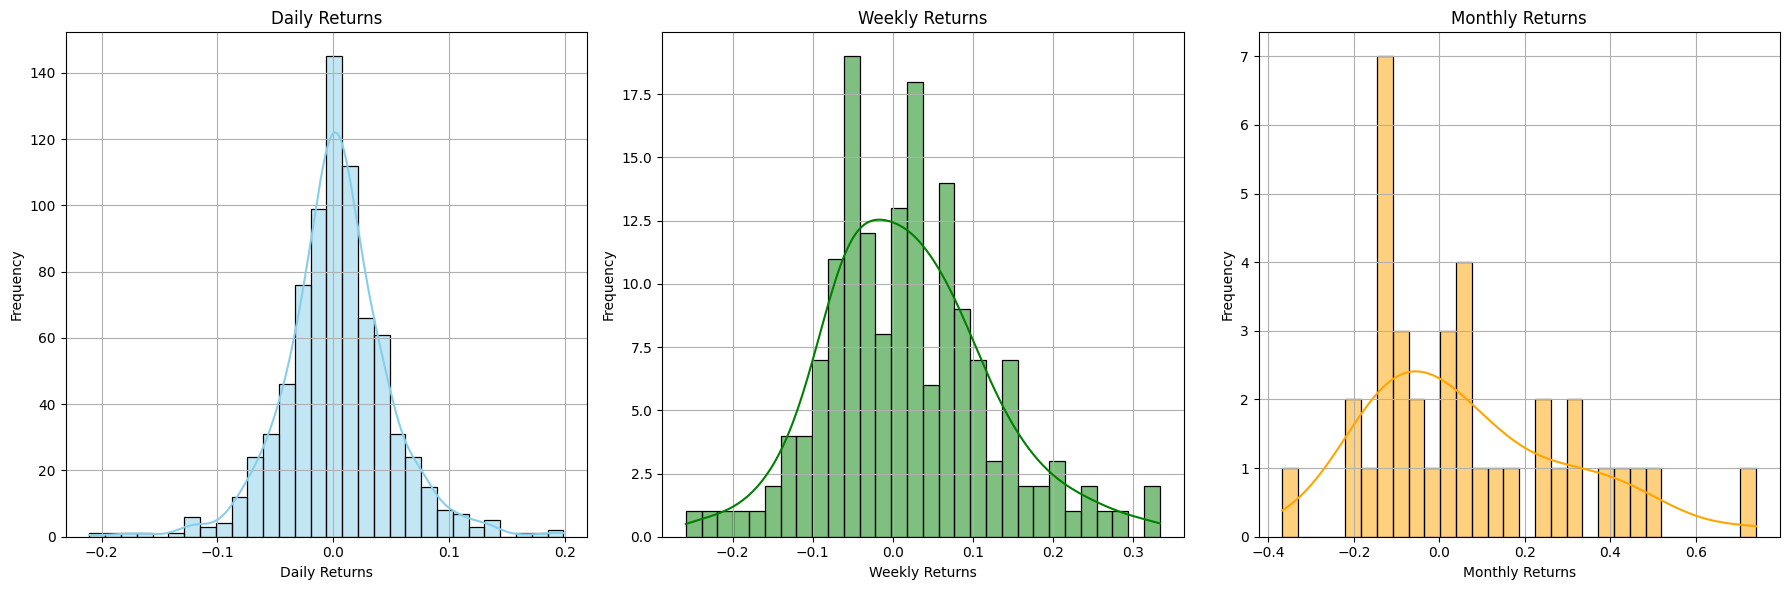

In [6]:
plot_returns_distributions(train_df_tsla)

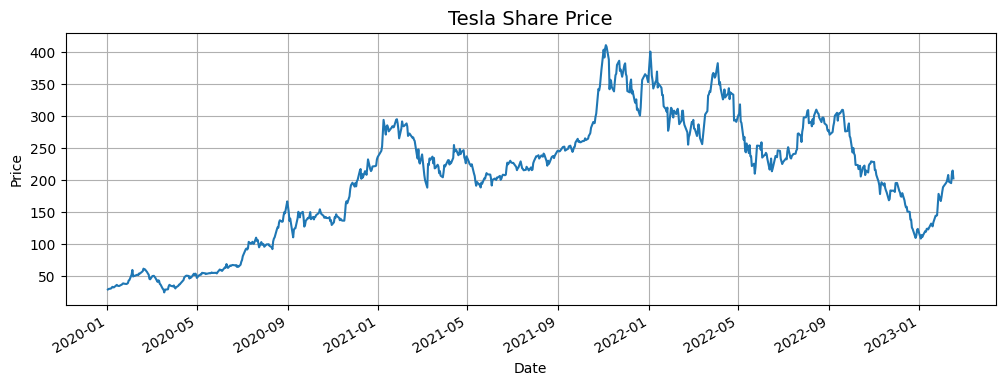

In [7]:
plot_share_price(train_df_tsla)

### Augmented Dickey–Fuller test

In [8]:
def adf_test(series):

    # Perform Augmented Dickey-Fuller test
    result = adfuller(series.values, autolag='AIC')

    # Print the results
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [9]:
adf_test(train_df_tsla)

ADF Statistic: -2.080858
p-value: 0.252281
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


The test statistic is positive, meaning we are much less likely to reject the null hypothesis (it looks non-stationary).

Comparing the test statistic to the critical values, it looks like we would have to fail to reject the null hypothesis that the time series is non-stationary and does have time-dependent structure.

In [10]:
adf_test(np.log(train_df_tsla))

ADF Statistic: -2.880258
p-value: 0.047692
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


In [11]:
adf_test(train_df_tsla.diff().dropna())

ADF Statistic: -8.166975
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


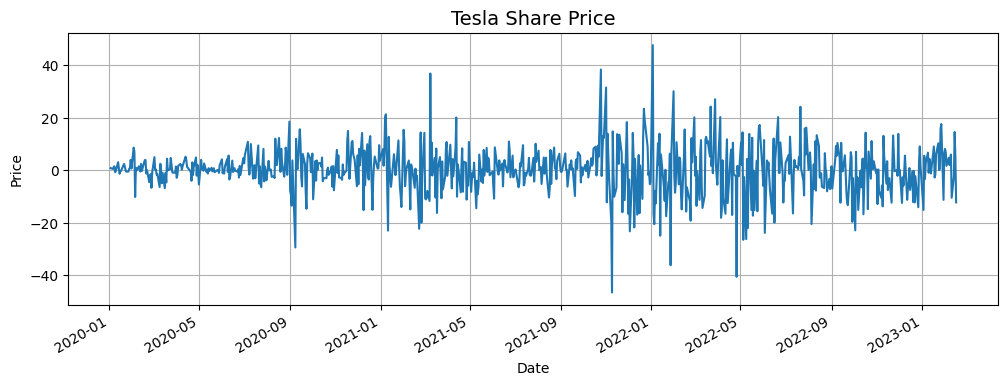

In [12]:
plot_share_price(diff_train_df_tsla)

### ARIMA Model

In [13]:
def plot_diagnosticsTight(data, rtn, title1 = 'TSLA'):

    fig, axes = plt.subplots(1,2,figsize=(15,5))
    axes[0].set_ylabel('ACF', fontsize=15)
    axes[0].set_xlabel('Lag', fontsize=15)
    fig = plot_acf(data,lags=25,zero=True, ax = axes[0], title= 'ACF '+ title1, use_vlines = True)
    axes[1].set_ylabel('ACF', fontsize=15)
    axes[1].set_xlabel('Lag', fontsize=15)
    fig = plot_acf(rtn,lags=25,zero=True, ax = axes[1], title= 'ACF Diff '+ title1, use_vlines = True)
    plt.tight_layout()

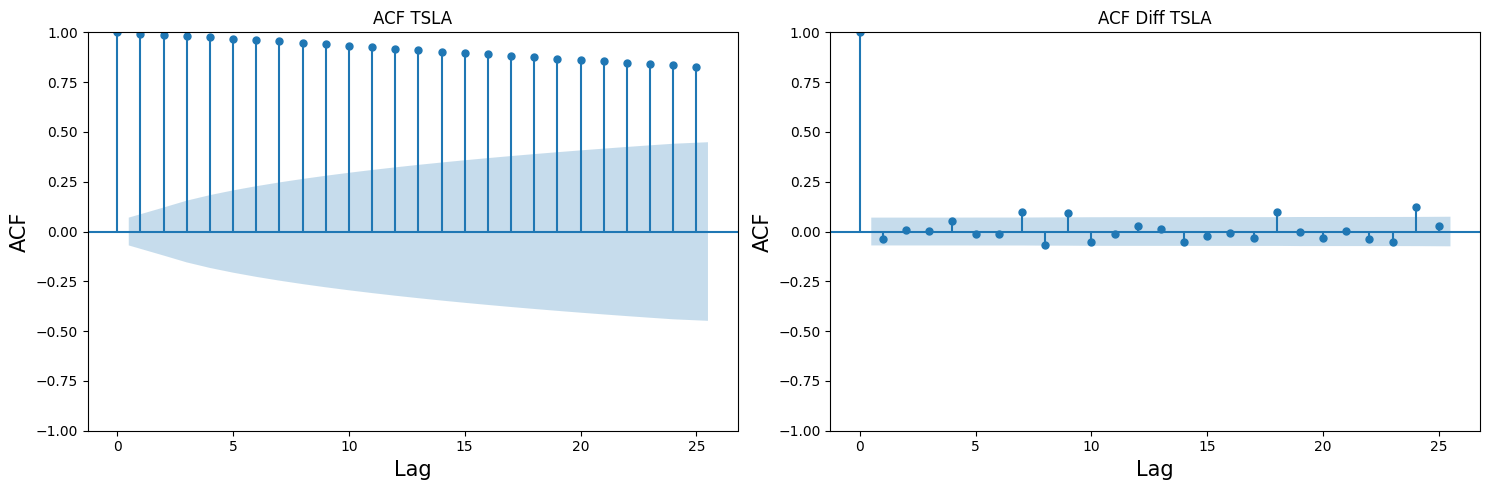

In [14]:
plot_diagnosticsTight(train_df_tsla, diff_train_df_tsla, title1 = 'TSLA')

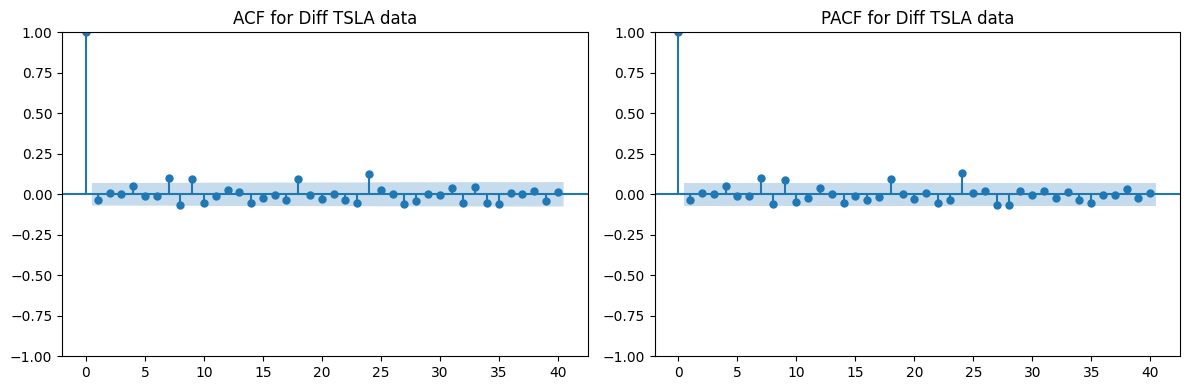

In [15]:
# Plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# ACF plot
sm.graphics.tsa.plot_acf(diff_train_df_tsla, lags=40, ax=ax1)
ax1.set_title('ACF for Diff TSLA data')

# PACF plot
sm.graphics.tsa.plot_pacf(diff_train_df_tsla, lags=40, ax=ax2)
ax2.set_title('PACF for Diff TSLA data')

plt.tight_layout()
plt.show()

In [16]:
def search_arma_model(data, max_p, max_q):
    aic_values = []
    bic_values = []

    for p in range(max_p + 1):
        for q in range(max_q + 1):
            model = sm.tsa.ARIMA(data.values, order=(p, 0, q))  # For ARMA, set d=0
            results = model.fit()
            aic = results.aic
            bic = results.bic
            aic_values.append(aic)
            bic_values.append(bic)

            print(f"p: {p}  q: {q}  aic: {aic}  bic: {bic}")

    return aic_values, bic_values

In [17]:
# Call the function with your data and maximum values for p and q
aic_values, bic_values = search_arma_model(log_train_df_tsla, max_p=6, max_q=3)

p: 0  q: 0  aic: -845.8003666913821  bic: -836.4613705116664
p: 0  q: 1  aic: -1860.9155529804032  bic: -1846.9070587108295


C:\Users\12134\anaconda3\envs\financial_project\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p: 0  q: 2  aic: -2614.274108488804  bic: -2595.5961161293726
p: 0  q: 3  aic: -3177.134733762332  bic: -3153.7872433130424
p: 1  q: 0  aic: -5004.93323785842  bic: -4990.9247435888465
p: 1  q: 1  aic: -5005.58255797196  bic: -4986.904565612529
p: 1  q: 2  aic: -5008.901414679706  bic: -4985.553924230417
p: 1  q: 3  aic: -5014.77103354839  bic: -4986.754045009243
p: 2  q: 0  aic: -5003.304435172951  bic: -4984.62644281352


C:\Users\12134\anaconda3\envs\financial_project\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


p: 2  q: 1  aic: -5015.435861394453  bic: -4992.088370945164


C:\Users\12134\anaconda3\envs\financial_project\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2  q: 2  aic: -5017.002557380584  bic: -4988.985568841437


C:\Users\12134\anaconda3\envs\financial_project\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2  q: 3  aic: -5019.118396197141  bic: -4986.431909568136
p: 3  q: 0  aic: -5006.3169324431  bic: -4982.9694419938105


C:\Users\12134\anaconda3\envs\financial_project\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3  q: 1  aic: -5014.742117767048  bic: -4986.725129227901
p: 3  q: 2  aic: -5018.339245120462  bic: -4985.652758491457
p: 3  q: 3  aic: -5020.423906930389  bic: -4983.067922211527
p: 4  q: 0  aic: -5010.105798602539  bic: -4982.088810063392
p: 4  q: 1  aic: -5018.630417612547  bic: -4985.943930983542


C:\Users\12134\anaconda3\envs\financial_project\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 4  q: 2  aic: -5015.004305970134  bic: -4977.648321251271
p: 4  q: 3  aic: -5016.6724928080575  bic: -4974.647009999337
p: 5  q: 0  aic: -5008.733938323986  bic: -4976.047451694981


C:\Users\12134\anaconda3\envs\financial_project\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 5  q: 1  aic: -5016.433631389567  bic: -4979.077646670705


C:\Users\12134\anaconda3\envs\financial_project\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 5  q: 2  aic: -5014.005166965678  bic: -4971.979684156957


C:\Users\12134\anaconda3\envs\financial_project\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 5  q: 3  aic: -5005.925291198238  bic: -4959.230310299658
p: 6  q: 0  aic: -5006.2355929198675  bic: -4968.879608201005


C:\Users\12134\anaconda3\envs\financial_project\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 6  q: 1  aic: -5015.915593649302  bic: -4973.890110840581


C:\Users\12134\anaconda3\envs\financial_project\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 6  q: 2  aic: -5016.512712289215  bic: -4969.817731390636
p: 6  q: 3  aic: -5002.12901063711  bic: -4950.764531648673


C:\Users\12134\anaconda3\envs\financial_project\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [18]:
# Call the function with your data and maximum values for p and q
aic_values, bic_values = search_arma_model(diff_train_df_tsla, max_p=6, max_q=3)

p: 0  q: 0  aic: 5683.821401654082  bic: 5693.1578581509175
p: 0  q: 1  aic: 5684.783582885677  bic: 5698.788267630929
p: 0  q: 2  aic: 5686.702501669309  bic: 5705.375414662978
p: 0  q: 3  aic: 5688.651117373541  bic: 5711.992258615628
p: 1  q: 0  aic: 5684.76342301242  bic: 5698.768107757673
p: 1  q: 1  aic: 5686.635430829265  bic: 5705.308343822934
p: 1  q: 2  aic: 5688.706912244506  bic: 5712.048053486594
p: 1  q: 3  aic: 5690.5794924537095  bic: 5718.588861944214
p: 2  q: 0  aic: 5686.702293276345  bic: 5705.375206270014
p: 2  q: 1  aic: 5687.7481588994815  bic: 5711.089300141569
p: 2  q: 2  aic: 5688.680297964196  bic: 5716.689667454701
p: 2  q: 3  aic: 5675.654495468284  bic: 5708.332093207206
p: 3  q: 0  aic: 5688.685062039688  bic: 5712.026203281775
p: 3  q: 1  aic: 5689.559857357887  bic: 5717.569226848392
p: 3  q: 2  aic: 5690.409523747092  bic: 5723.0871214860135
p: 3  q: 3  aic: 5675.76356474276  bic: 5713.109390730099
p: 4  q: 0  aic: 5688.519034684121  bic: 5716.52840417

C:\Users\12134\anaconda3\envs\financial_project\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 4  q: 3  aic: 5676.270250156226  bic: 5718.284304391983
p: 5  q: 0  aic: 5690.443076965883  bic: 5723.1206747048045
p: 5  q: 1  aic: 5692.43946283357  bic: 5729.78528882091
p: 5  q: 2  aic: 5681.13330207707  bic: 5723.147356312827


C:\Users\12134\anaconda3\envs\financial_project\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 5  q: 3  aic: 5678.147551611883  bic: 5724.829834096056
p: 6  q: 0  aic: 5692.3013843026265  bic: 5729.647210289966
p: 6  q: 1  aic: 5684.8134274920885  bic: 5726.827481727845
p: 6  q: 2  aic: 5681.893079361225  bic: 5728.575361845399
p: 6  q: 3  aic: 5680.0581246118945  bic: 5731.408635344486


C:\Users\12134\anaconda3\envs\financial_project\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


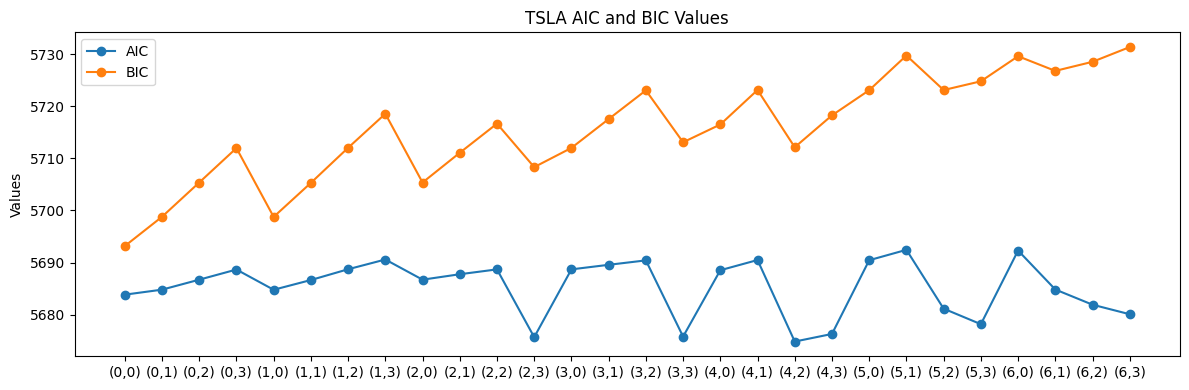

In [19]:
# Define max_p and max_q
max_p = 6
max_q = 3

# Visualize AIC and BIC values in one chart
p_values = range(max_p + 1)
q_values = range(max_q + 1)

fig, ax = plt.subplots(figsize=(12, 4))
tick_labels = []

ax.plot(aic_values, marker='o', label='AIC')
ax.plot(bic_values, marker='o', label='BIC')
ax.set_xticks(range(len(aic_values)))
for p in p_values:
    for q in q_values:
        tick_labels.append(f'({p},{q})')
ax.set_xticklabels(tick_labels)
ax.set_ylabel('Values')
ax.set_title('TSLA AIC and BIC Values')
ax.legend()

plt.tight_layout()
plt.show()

In [24]:
# Number of days to use for the rolling window
window_size = 10

# Create an empty list to store the predictions
train_predictions = []

# Iterate over the dataset using a rolling window
for t in range(window_size, len(diff_train_df_tsla)):
    # Select the current rolling window of data
    current_window = diff_train_df_tsla.values[t - window_size : t]

    # Fit the ARIMA model for the current window
    model = sm.tsa.ARIMA(current_window, order=(0, 0, 0))
    model_fit = model.fit()

    # Forecast the next day's value
    forecasted_value = model_fit.forecast(steps=1)

    # Append the forecasted value to the list of predictions
    train_predictions.append(forecasted_value[0])

In [25]:
# Convert the differenced predictions to actual values
train_predictions = np.cumsum(train_predictions) + train_df_tsla.values[window_size]

# Calculate MSPE
mse = mean_squared_error(train_df_tsla.values[window_size+1:], train_predictions)
rmse = np.sqrt(mse)

# Print RMSE
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 17.772003125867975


In [26]:
# Create an empty list to store the predictions
test_predictions = []

# Iterate over the dataset using a rolling window
for t in range(window_size, len(diff_test_df_tsla)):
    # Select the current rolling window of data
    current_window = diff_test_df_tsla.values[t - window_size : t]

    # Fit the ARIMA model for the current window
    model = sm.tsa.ARIMA(current_window, order=(0, 0, 0))
    model_fit = model.fit()

    # Forecast the next day's value
    forecasted_value = model_fit.forecast(steps=1)

    # Append the forecasted value to the list of predictions
    test_predictions.append(forecasted_value[0])

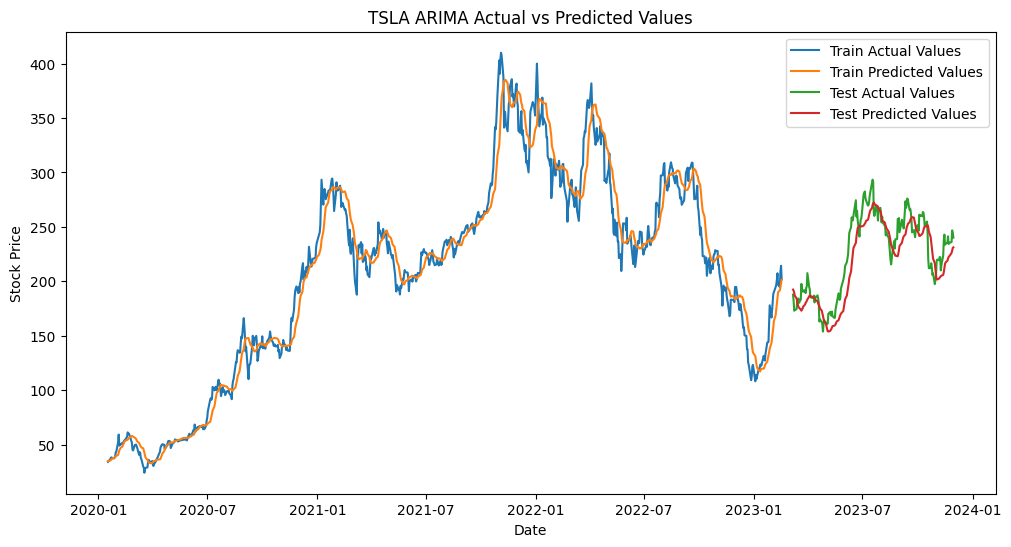

Root Mean Squared Error (RMSE): 17.16351565715647


In [27]:
# Convert the differenced predictions to actual values
test_predictions = np.cumsum(test_predictions) + test_df_tsla.values[window_size]

# Calculate MSPE
mse = mean_squared_error(test_df_tsla.values[window_size+1:], test_predictions)
rmse = np.sqrt(mse)

# Visualize actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(train_df_tsla.index[window_size+1:], train_df_tsla.values[window_size+1:], label='Train Actual Values')
plt.plot(train_df_tsla.index[window_size+1:], train_predictions, label='Train Predicted Values')
plt.plot(test_df_tsla.index[window_size+1:], test_df_tsla.values[window_size+1:], label='Test Actual Values')
plt.plot(test_df_tsla.index[window_size+1:], test_predictions, label='Test Predicted Values')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('TSLA ARIMA Actual vs Predicted Values')
plt.legend()
plt.show()

# Print RMSE
print(f"Root Mean Squared Error (RMSE): {rmse}")

### ARIMA Model Residule Analysis

## LSTM Model

In [28]:
dataset = df_tsla.values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [29]:
training_data_len = int(np.ceil( len(dataset) * .8 ))

In [30]:
# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(10, len(train_data)):
    x_train.append(train_data[i-10:i, 0])
    y_train.append(train_data[i, 0])
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [31]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(4, input_shape= (x_train.shape[1], 1)))
model.add(Dense(1))
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
# Train the model
history = model.fit(x_train, y_train, batch_size=256, epochs=100, verbose=2)



Epoch 1/100

4/4 - 2s - loss: 0.4454 - 2s/epoch - 504ms/step
Epoch 2/100
4/4 - 0s - loss: 0.4262 - 23ms/epoch - 6ms/step
Epoch 3/100
4/4 - 0s - loss: 0.4079 - 23ms/epoch - 6ms/step
Epoch 4/100
4/4 - 0s - loss: 0.3909 - 22ms/epoch - 6ms/step
Epoch 5/100
4/4 - 0s - loss: 0.3746 - 24ms/epoch - 6ms/step
Epoch 6/100
4/4 - 0s - loss: 0.3592 - 23ms/epoch - 6ms/step
Epoch 7/100
4/4 - 0s - loss: 0.3446 - 22ms/epoch - 6ms/step
Epoch 8/100
4/4 - 0s - loss: 0.3306 - 25ms/epoch - 6ms/step
Epoch 9/100
4/4 - 0s - loss: 0.3170 - 24ms/epoch - 6ms/step
Epoch 10/100
4/4 - 0s - loss: 0.3039 - 22ms/epoch - 6ms/step
Epoch 11/100
4/4 - 0s - loss: 0.2912 - 22ms/epoch - 6ms/step
Epoch 12/100
4/4 - 0s - loss: 0.2789 - 22ms/epoch - 5ms/step
Epoch 13/100
4/4 - 0s - loss: 0.2667 - 23ms/epoch - 6ms/step
Epoch 14/100
4/4 - 0s - loss: 0.2547 - 23ms/epoch - 6ms/step
Epoch 15/100
4/4 - 0s - loss: 0.2430 - 24ms/epoch - 6ms/step
Epoch 16/100
4/4 - 0s - loss: 0.2314 - 23ms/epoch - 6ms/step
Epoch 17/100
4/4 - 0s - loss: 

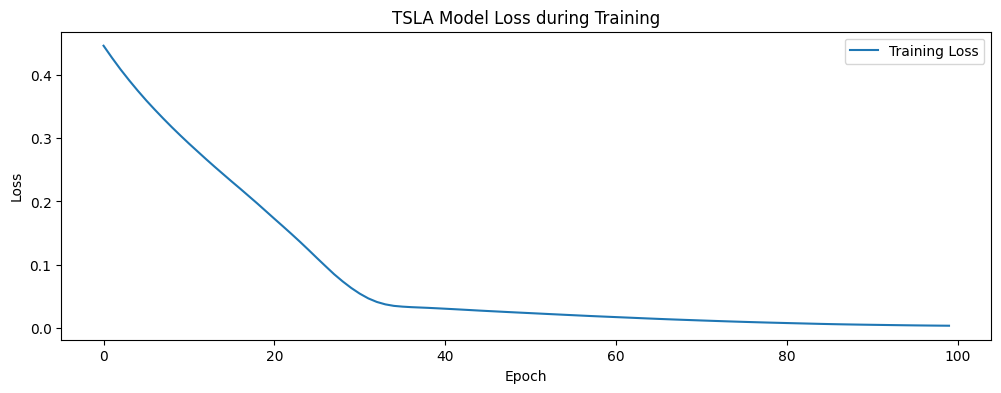

In [36]:
# Visualize the training loss
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'])
plt.title('TSLA Model Loss during Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss'], loc='upper right')
plt.show()

A downward trend in the loss plot would be indicative of model convergence.

In [33]:
# Get the models predicted price values 
train_predictions = model.predict(x_train)
train_predictions = scaler.inverse_transform(train_predictions)
y_train_unscaled = dataset[10:training_data_len, :]

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((train_predictions - y_train_unscaled) ** 2)))
print('train rmse: ',rmse)

25/25 [==============================] - 1s 3ms/step
train rmse:  24.12385927247996


In [34]:
# Create the testing data set
test_data = scaled_data[training_data_len - 10: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(10, len(test_data)):
    x_test.append(test_data[i-10:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print('test rmse: ',rmse)

7/7 [==============================] - 0s 3ms/step
test rmse:  14.201753401910612


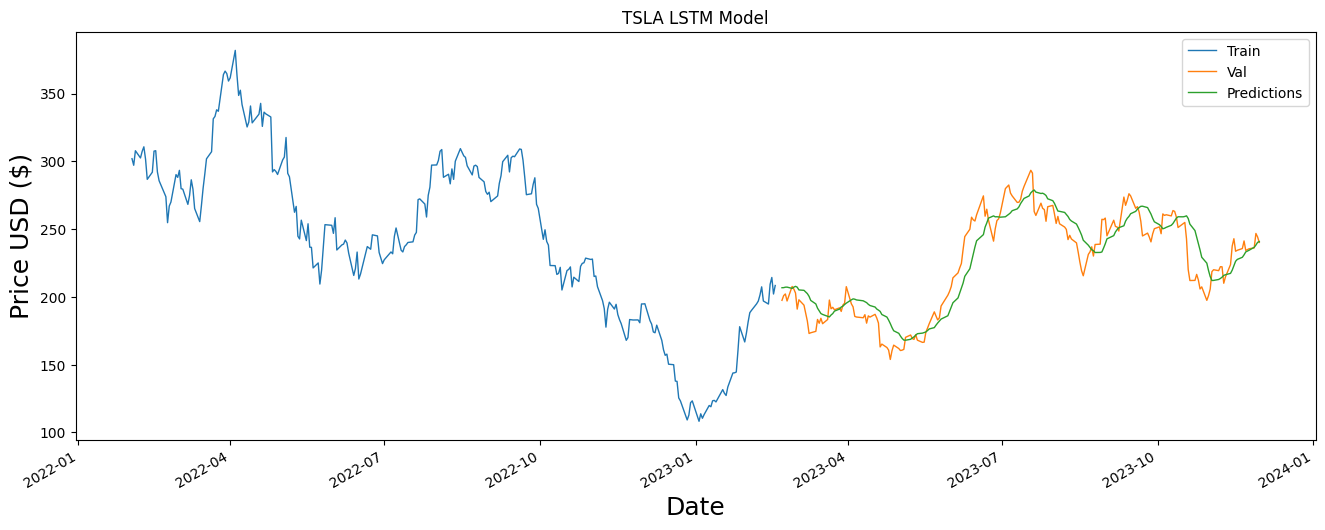

In [35]:
data = df_tsla.to_frame(name='price')

train = data[int(training_data_len/3*2):training_data_len]
valid = data[training_data_len:]
valid = data[training_data_len:].copy()
valid['Predictions'] = predictions

train.index = pd.to_datetime(train.index)
valid.index = pd.to_datetime(valid.index)

# Visualize the data
plt.figure(figsize=(16,6))
plt.title('TSLA LSTM Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price USD ($)', fontsize=18)
plt.plot(train['price'], linewidth=1)
plt.plot(valid[['price', 'Predictions']], linewidth=1)
plt.legend(['Train', 'Val', 'Predictions'], loc='upper right')
plt.gcf().autofmt_xdate()
plt.show()